In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
from __future__ import unicode_literals

import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

In [2]:
sns.set()
sns.set_style("whitegrid")
sns.set_context("poster")

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'


# Introduction

The goal here is to test if there is a data leakage in the skewing of the Higgs data

In [3]:
from problem.workflow import pprint

## Load data

In [4]:
from problem.higgs_geant import load_data

In [5]:
print('Loading data ...')
data, _ = load_data()
print('Done !')

Loading data ...
Done !


In [6]:
data.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,1.0
1,160.937,68.768,103.235,48.146,0.00,0.000,0.000,3.473,2.078,125.157,...,1,46.226,0.725,1.158,0.000,0.00,0.000,46.226,0.681042,0.0
2,0.000,162.172,125.953,35.635,0.00,0.000,0.000,3.148,9.336,197.814,...,1,44.251,2.053,-2.028,0.000,0.00,0.000,44.251,0.715742,0.0
3,143.905,81.417,80.943,0.414,0.00,0.000,0.000,3.310,0.414,75.968,...,0,0.000,0.000,0.000,0.000,0.00,0.000,-0.000,1.660654,0.0
4,175.864,16.915,134.805,16.405,0.00,0.000,0.000,3.891,16.405,57.983,...,0,0.000,0.000,0.000,0.000,0.00,0.000,0.000,1.904263,0.0


## Skewing function

In [7]:
from problem.higgs_geant import get_save_directory
from problem.higgs_geant import skew
from problem.higgs_geant import skewing_function
from problem.higgs_geant import tangent
from problem.higgs_geant import get_cv_iter


# Visualization




In [8]:
z = 1.05

## Difference

In [20]:
diff = skew(data) - skew(data, z)

### Changed columns

In [21]:
changed_cols = [c for c in diff if np.any( diff[c] != 0 )]
unchanged_cols = [c for c in diff if np.all( diff[c] == 0 )]

### Histograms

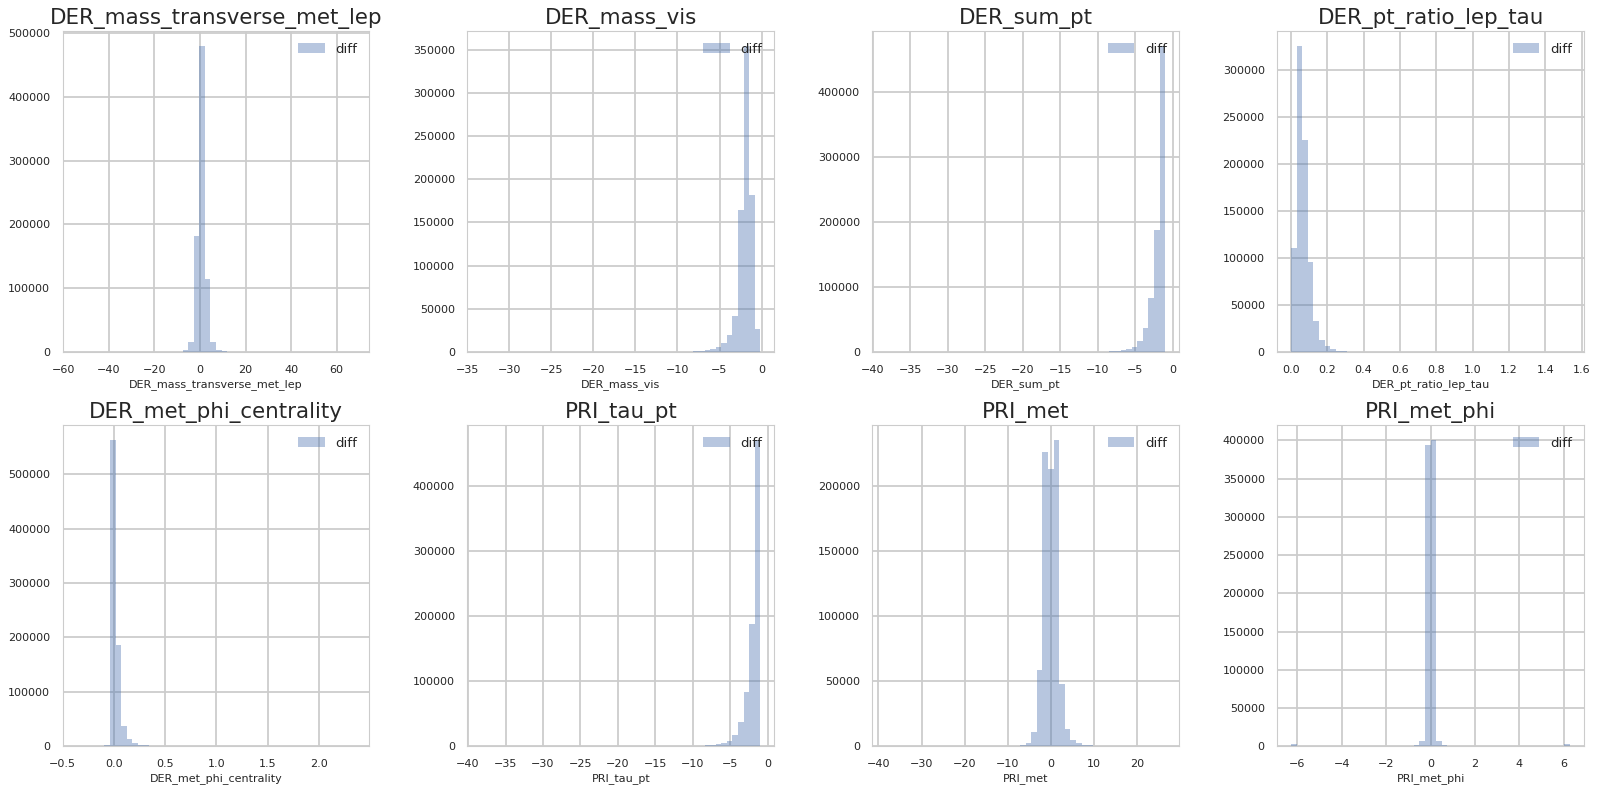

In [22]:
cols = changed_cols

n_features = len(cols)
n_plot_cols = 4
n_plot_raws = n_features//n_plot_cols + (1 if (n_features % n_plot_cols) > 0 else 0 )
fig, axes = plt.subplots(n_plot_raws, n_plot_cols, figsize=(5*n_plot_cols,5*n_plot_raws))
axes = axes.ravel()

for i in range(n_features):
    sns.distplot(diff[cols[i]], ax=axes[i], label='diff', kde=False)
    axes[i].set_title(cols[i])  # Title = feature name
    axes[i].legend(loc=1)

plt.tight_layout()  # Avoid plot collision
plt.show()

### Sanity check

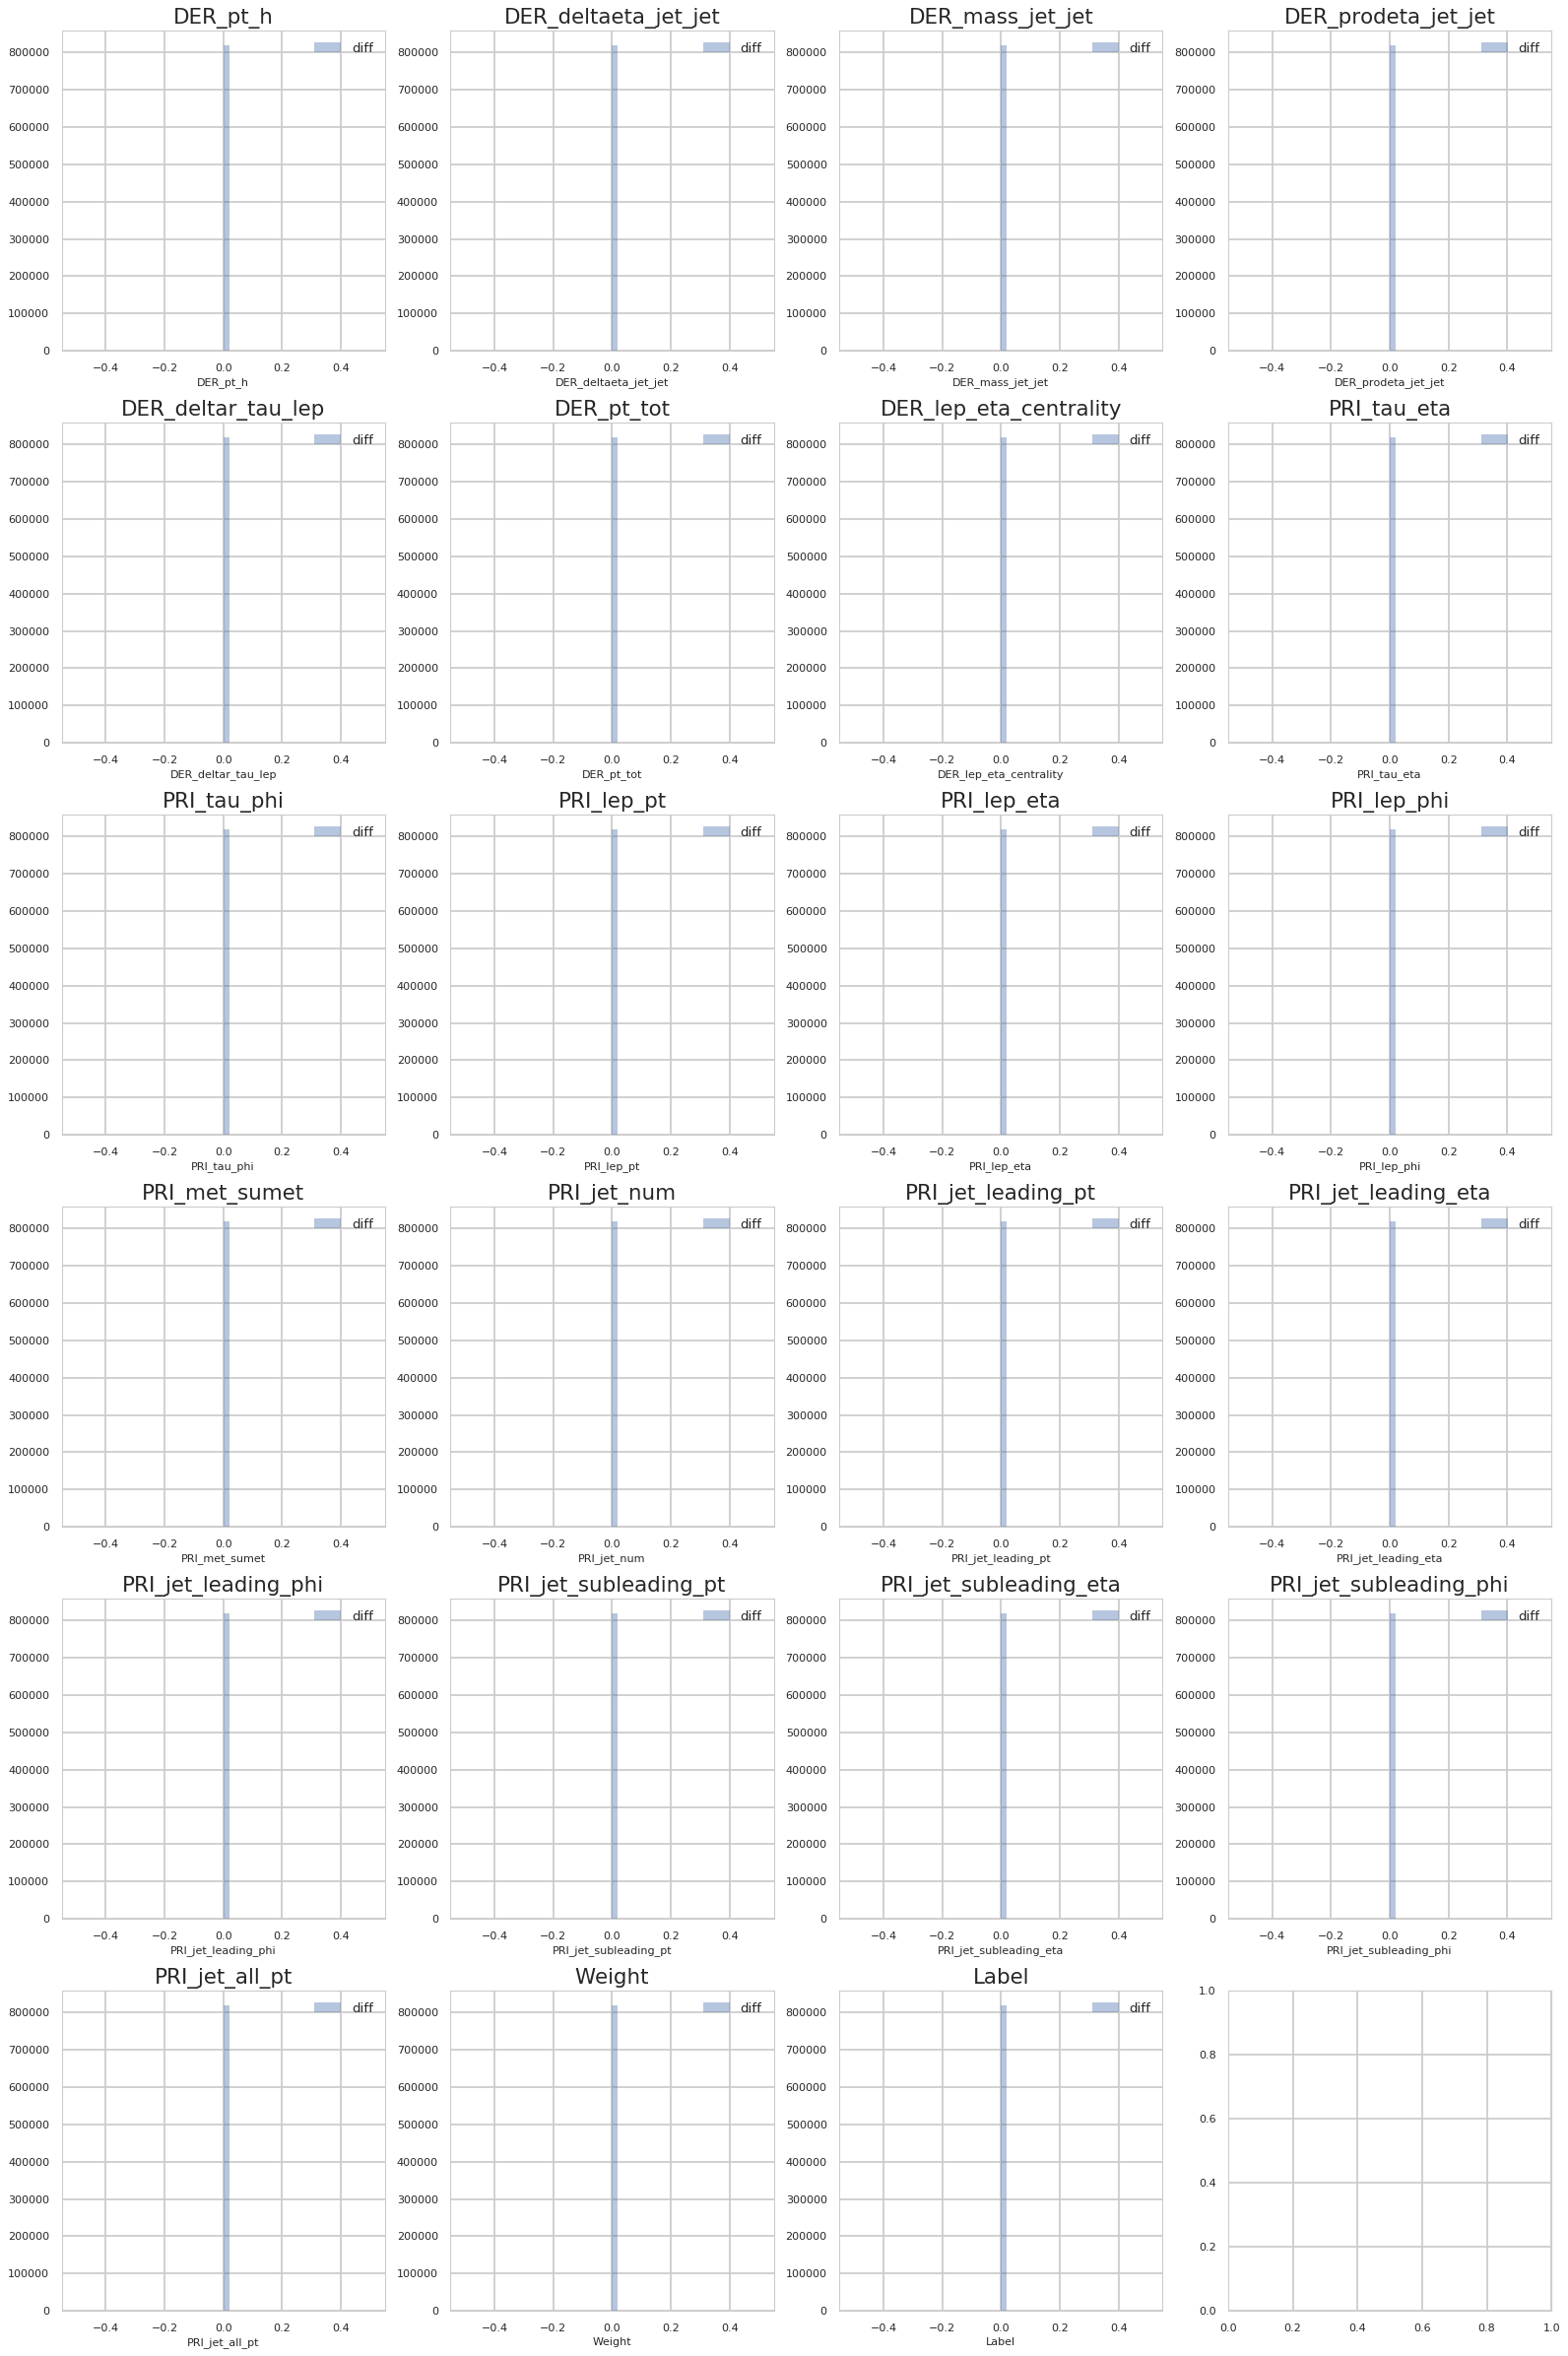

In [23]:
cols = unchanged_cols

n_features = len(cols)
n_plot_cols = 4
n_plot_raws = n_features//n_plot_cols + (1 if (n_features % n_plot_cols) > 0 else 0 )
fig, axes = plt.subplots(n_plot_raws, n_plot_cols, figsize=(5*n_plot_cols,5*n_plot_raws))
axes = axes.ravel()

for i in range(n_features):
    sns.distplot(diff[cols[i]], ax=axes[i], label='diff', kde=False)
    axes[i].set_title(cols[i])  # Title = feature name
    axes[i].legend(loc=1)

plt.tight_layout()  # Avoid plot collision
plt.show()

## Relative difference

In [10]:
diff = skew(data) - skew(data, z)
diff = diff / (skew(data) + 1e-8)
diff.fillna(0.0, inplace=True)

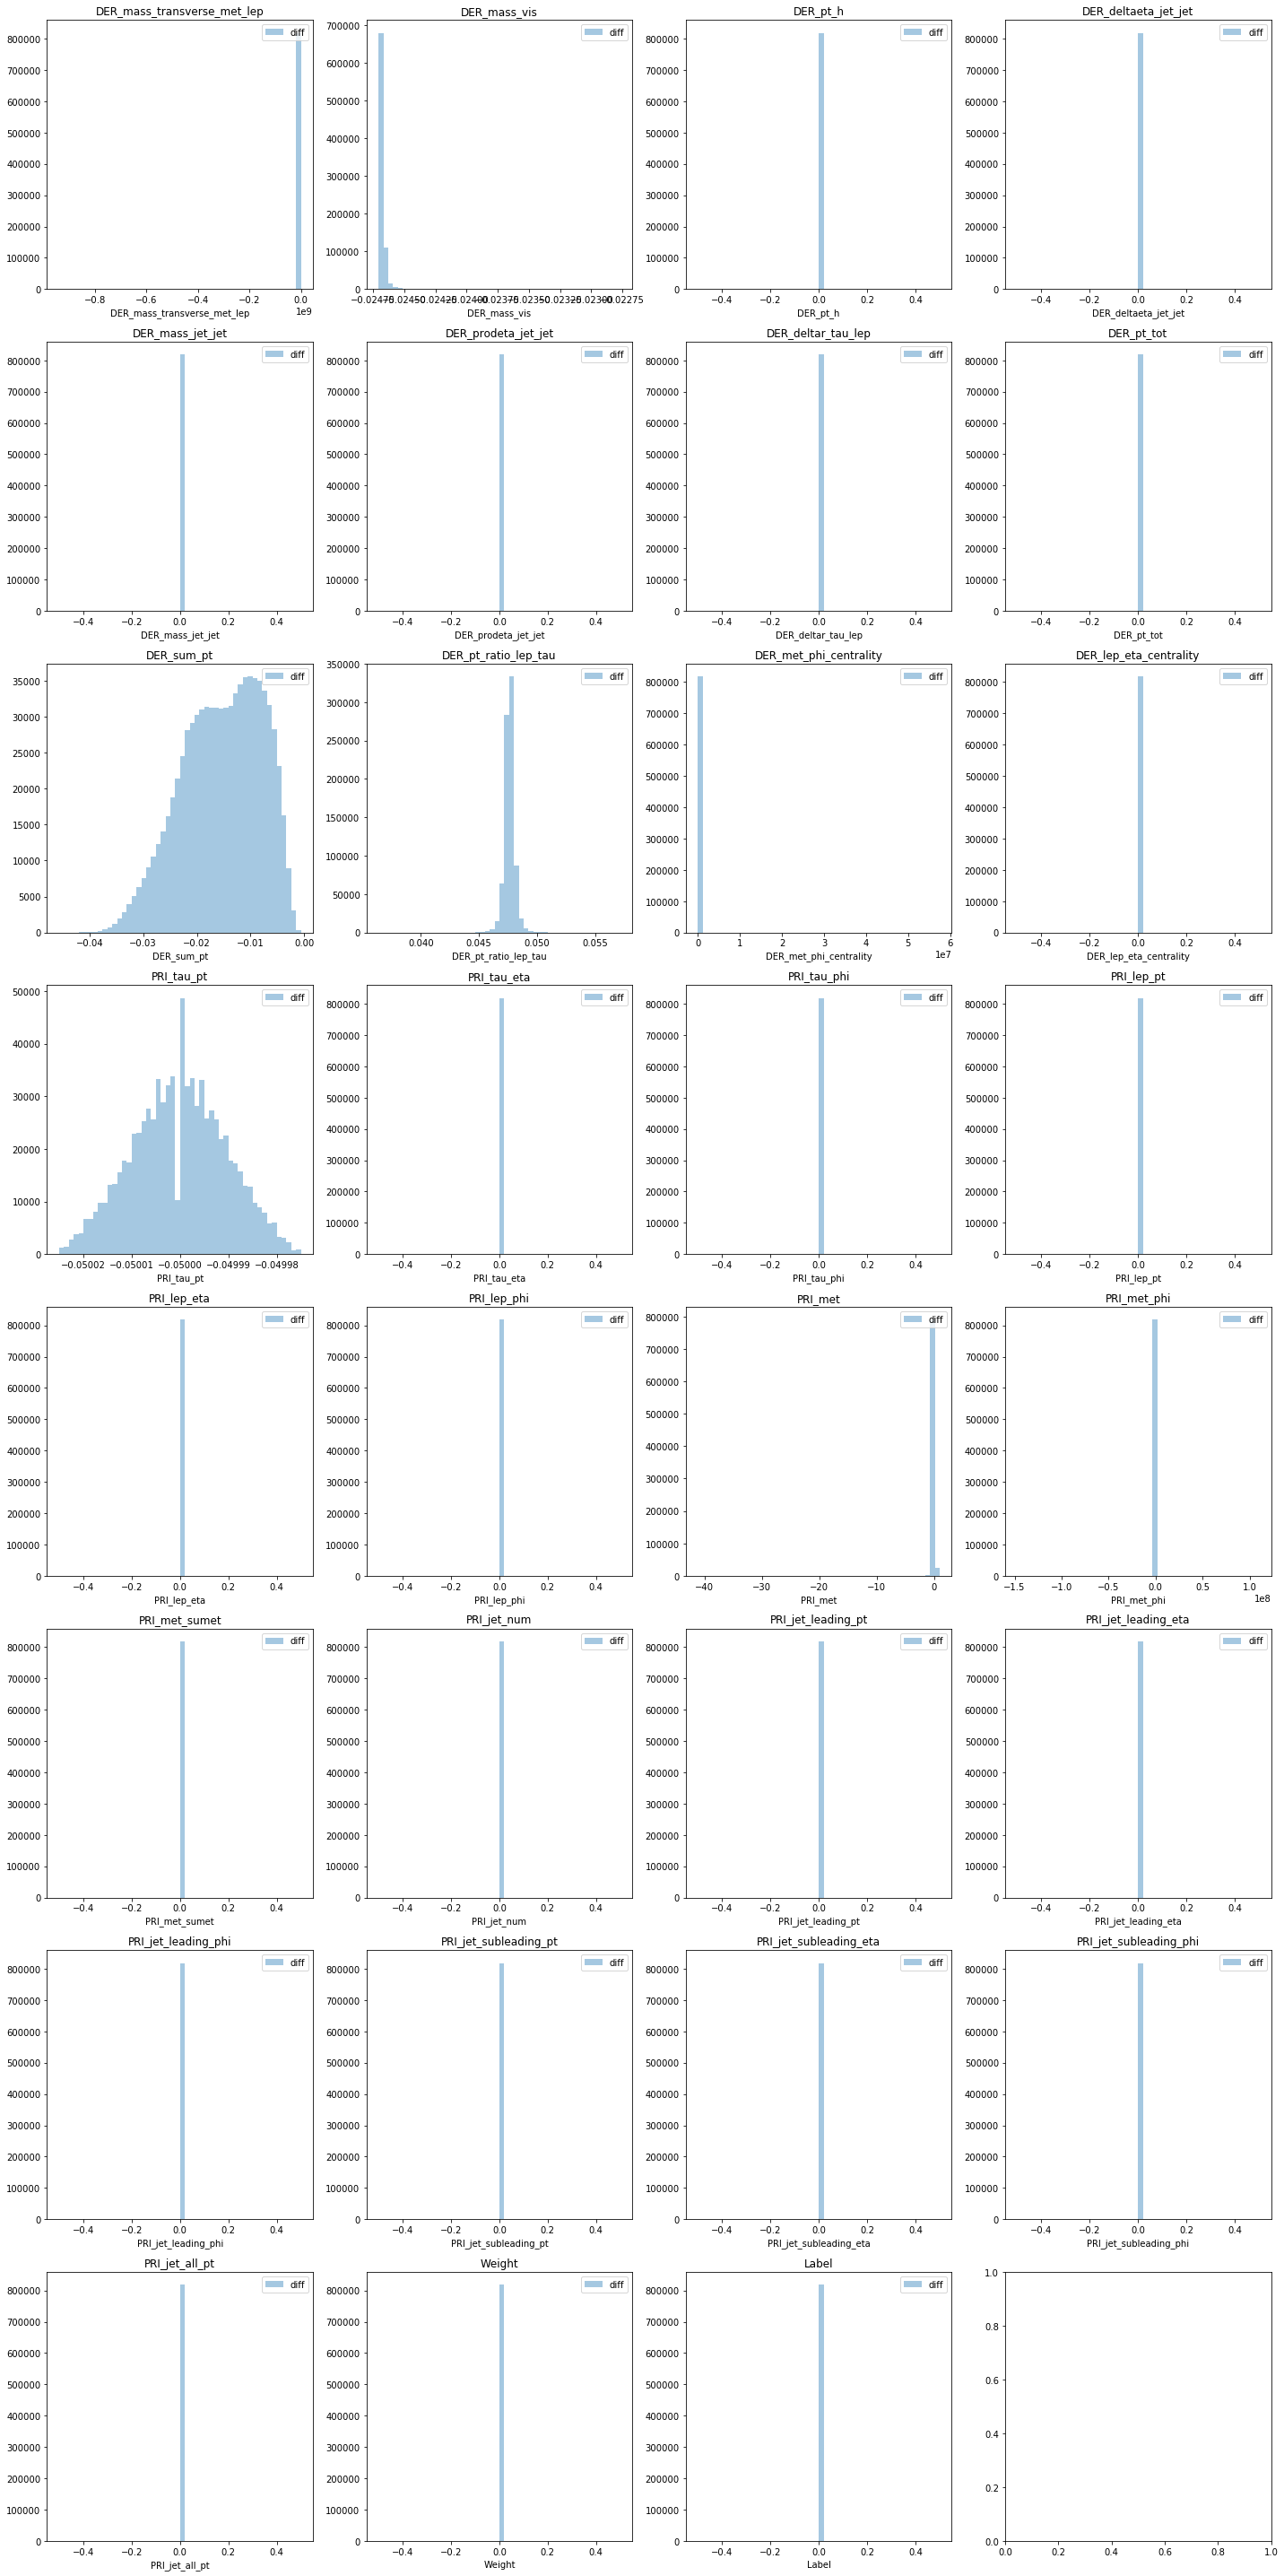

In [11]:
cols = diff.columns  # get column names to do indexing on pandas.DataFrames

n_features = len(cols)
n_plot_cols = 4
n_plot_raws = n_features//n_plot_cols + (1 if (n_features % n_plot_cols) > 0 else 0 )
fig, axes = plt.subplots(n_plot_raws, n_plot_cols, figsize=(5*n_plot_cols,5*n_plot_raws))
axes = axes.ravel()

for i in range(n_features):
    sns.distplot(diff[cols[i]], ax=axes[i], label='diff', kde=False)
    axes[i].set_title(cols[i])  # Title = feature name
    axes[i].legend(loc=1)

plt.tight_layout()  # Avoid plot collision
plt.show()

# Classification 

Here I measure the capacity of some classifier to separate between nominal data and skewed data.

If there is a data leakage, maybe some classfier will have very good performances on this task.

In [9]:
sns.set()
sns.set_style("whitegrid")
sns.set_context("poster")

mpl.rcParams['figure.figsize'] = [8.0*2, 6.0*2]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 30
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'


In [10]:
z = 1.05

## Build problem

I need 4 parts
0. the train unskewed
0. the train skewed
0. the test unskewed
0. the test skewed

In [11]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import check_cv
from sklearn.model_selection import train_test_split


In [12]:
def make_classification(data, z):
    data_0, data_1 = train_test_split(data, test_size=0.5)
    data_0 = skewing_function (data_0 )
    data_1 = skewing_function(data_1, z)
    X = pd.concat([data_0.drop(["Weight"], axis=1), data_1.drop(["Weight"], axis=1)] )
    y = np.concatenate( (np.zeros(data_0.shape[0]), np.ones(data_1.shape[0])) )
    return X, y


In [13]:
def cv_score(model, X, y, cv=ShuffleSplit(n_splits=3, test_size=0.2)):
    cv = check_cv(cv)
    train_scores = []
    test_scores = []
    for train_idx, test_idx in cv.split(X, y):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]
        
        model.fit(X_train, y_train)
        
        sc = model.score(X_train, y_train)
        train_scores.append(sc)
        
        sc = model.score(X_test, y_test)
        test_scores.append(sc)
    
    return train_scores, test_scores


In [14]:
def test_all_z(model, data, z_list=(0.95, 1.0, 1.05)):
    many_z = []
    train_scores = []
    test_scores = []
    
    for z in z_list:
        pprint( 'testing z = {} ...'.format(z) )
        X, y = make_classification(data, z)
        cv = ShuffleSplit(n_splits=3, test_size=0.2)
        n_cv = cv.n_splits
        train_sc, test_sc = cv_score(model, X.values, y, cv=cv)
        
        many_z.extend([z]*n_cv)
        train_scores.extend(train_sc)
        test_scores.extend(test_sc)
    return many_z, train_scores, test_scores
        

## Gradient Boosting

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

In [52]:
grad_boost = GradientBoostingClassifier()
z_list = [0.90, 0.92, 0.95, 0.98, 1.0, 1.02, 1.05, 1.08, 1.10]

In [53]:
many_z, train_scores, test_scores = test_all_z(grad_boost, data, z_list=z_list)

2018-03-12 09:22:38 testing z = 0.9 ...
2018-03-12 09:30:48 testing z = 0.92 ...
2018-03-12 09:39:08 testing z = 0.95 ...
2018-03-12 09:47:36 testing z = 0.98 ...
2018-03-12 09:56:10 testing z = 1.0 ...
2018-03-12 10:04:50 testing z = 1.02 ...
2018-03-12 10:13:46 testing z = 1.05 ...
2018-03-12 10:22:58 testing z = 1.08 ...
2018-03-12 10:32:27 testing z = 1.1 ...


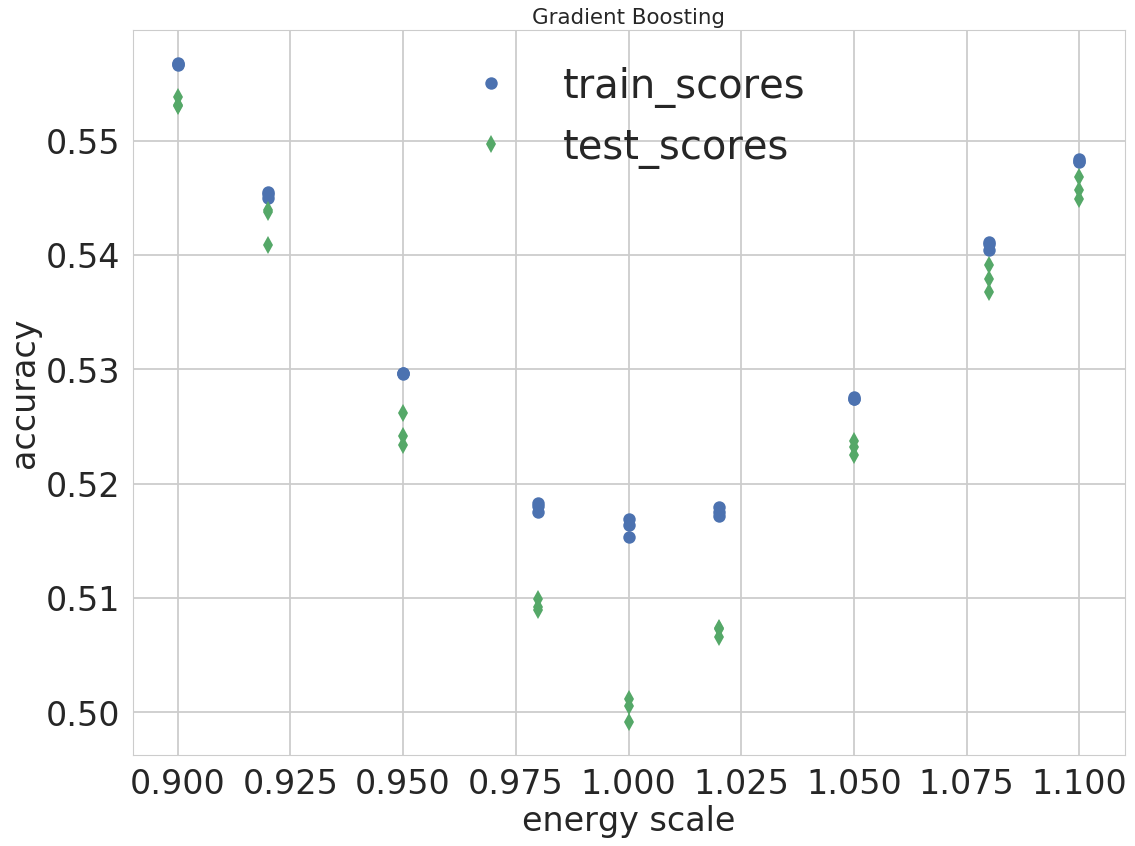

In [54]:
plt.plot(many_z, train_scores, 'o', label='train_scores')
plt.plot(many_z, test_scores, 'd', label='test_scores')
plt.title('Gradient Boosting')
plt.xlabel('energy scale')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Neural net

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

from models.net.minibatch import OneEpoch, EpochShuffle
from itertools import islice


In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(30, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def reset_parameters(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()
        self.fc3.reset_parameters()
        self.bn1.reset_parameters()
        self.bn2.reset_parameters()


In [18]:

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

from models.net.neural_net import NeuralNetClassifier
from models.net.weighted_criterion import WeightedCrossEntropyLoss

from models.monitor import LossMonitorHook

class NeuralNetModel(BaseEstimator, ClassifierMixin):
    def __init__(self, n_steps=5000, batch_size=1024, learning_rate=1e-3, cuda=False, verbose=0):
        super().__init__()
        self.n_steps = n_steps
        self.batch_size = batch_size
        self.cuda = cuda
        self.verbose = verbose
        
        self.net = Net()
        
        self.learning_rate = learning_rate
        self.optimizer = optim.Adam(self.net.parameters(), lr=learning_rate)
        self.criterion = WeightedCrossEntropyLoss()
        
        self.loss_hook = LossMonitorHook()
        self.criterion.register_forward_hook(self.loss_hook)
        
        self.scaler = StandardScaler()
        self.clf = NeuralNetClassifier(self.net, self.criterion, self.optimizer, 
                                       n_steps=self.n_steps, batch_size=self.batch_size, cuda=cuda)

    def fit(self, X, y, sample_weight=None):
        if isinstance(X, pd.core.generic.NDFrame):
            X = X.values
        if isinstance(y, pd.core.generic.NDFrame):
            y = y.values
        if isinstance(sample_weight, pd.core.generic.NDFrame):
            sample_weight = sample_weight.values
        X = self.scaler.fit_transform(X)
        self.loss_hook.reset()
        self.clf.fit(X, y, sample_weight=sample_weight)
        return self
    
    def predict(self, X):
        if isinstance(X, pd.core.generic.NDFrame):
            X = X.values
        X = self.scaler.transform(X)
        y_pred = self.clf.predict(X)
        return y_pred
    
    def predict_proba(self, X):
        if isinstance(X, pd.core.generic.NDFrame):
            X = X.values
        X = self.scaler.transform(X)
        proba = self.clf.predict_proba(X)
        return proba


In [47]:
nn_clf = NeuralNetModel(learning_rate=1e-3)
z_list = [0.90, 0.92, 0.95, 0.98, 1.0, 1.02, 1.05, 1.08, 1.10]

In [48]:
many_z, train_scores, test_scores = test_all_z(nn_clf, data, z_list=z_list)

2018-03-12 08:59:43 testing z = 0.9 ...
2018-03-12 09:01:47 testing z = 0.92 ...
2018-03-12 09:03:40 testing z = 0.95 ...
2018-03-12 09:05:42 testing z = 0.98 ...
2018-03-12 09:07:54 testing z = 1.0 ...
2018-03-12 09:09:56 testing z = 1.02 ...
2018-03-12 09:12:03 testing z = 1.05 ...
2018-03-12 09:14:11 testing z = 1.08 ...
2018-03-12 09:16:16 testing z = 1.1 ...


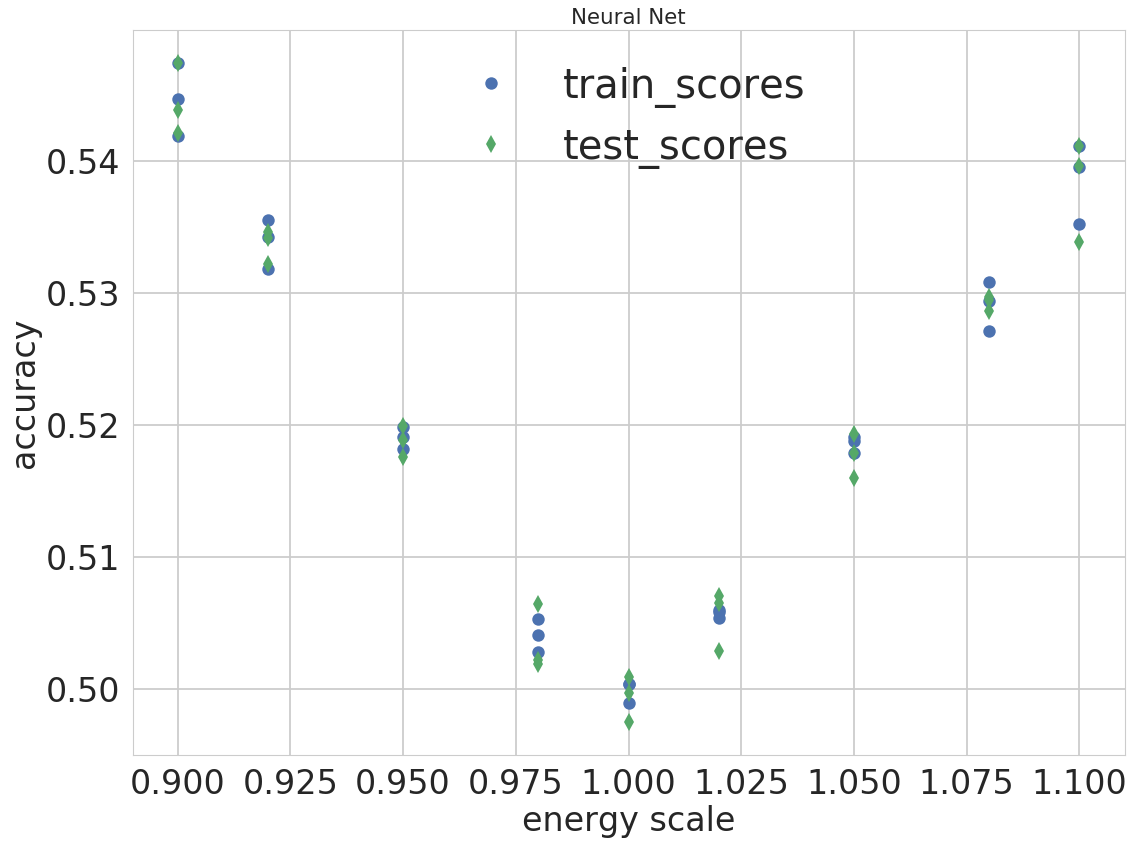

In [50]:
plt.plot(many_z, train_scores, 'o', label='train_scores')
plt.plot(many_z, test_scores, 'd', label='test_scores')
plt.title('Neural Net')
plt.xlabel('energy scale')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Regression

# $\chi^2$ test

In [22]:
from scipy.stats import chisquare
z = 1.03

## Neural network

In [117]:
model = NeuralNetModel(learning_rate=1e-3, batch_size=1024, n_steps=100000, cuda=True)

X, y = make_classification(data, z)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

### Training

In [118]:
model.fit(X_train, y_train)

NeuralNetModel(batch_size=1024, cuda=True, learning_rate=0.001,
        n_steps=100000, verbose=0)

### Losses

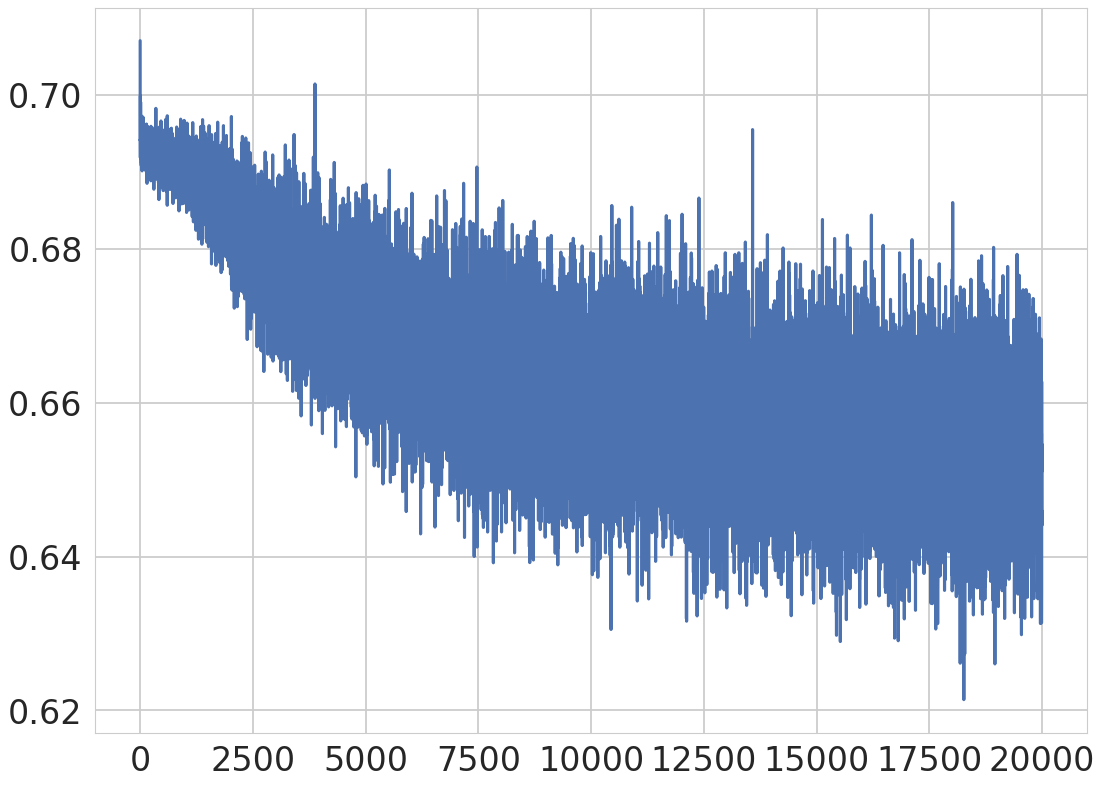

In [119]:
plt.plot(model.loss_hook.losses[::5])
plt.show()

### Prediction

In [158]:
proba = model.predict_proba(X_test)

threshold = 0.5

y_pred = np.asarray(proba[:, 1] > threshold, dtype=int)

score_nominal = proba[y_test==0, 1]
score_skewed = proba[y_test==1, 1]

### Score distribution

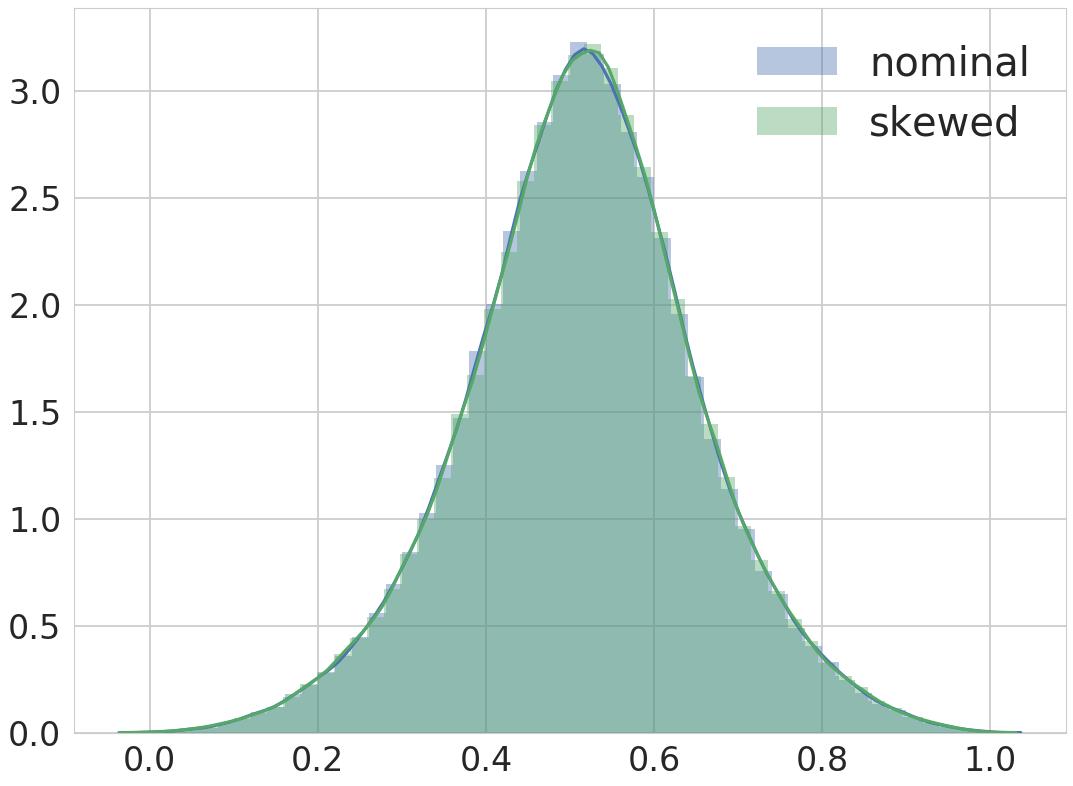

In [181]:
sns.distplot(score_nominal, label='nominal')
sns.distplot(score_skewed, label='skewed')

plt.legend()
plt.show()


### Confusion matrix

In [160]:
from sklearn.metrics import confusion_matrix
import itertools

80446 92061.5
99528 92061.5
83379 92061.5
103677 92061.5


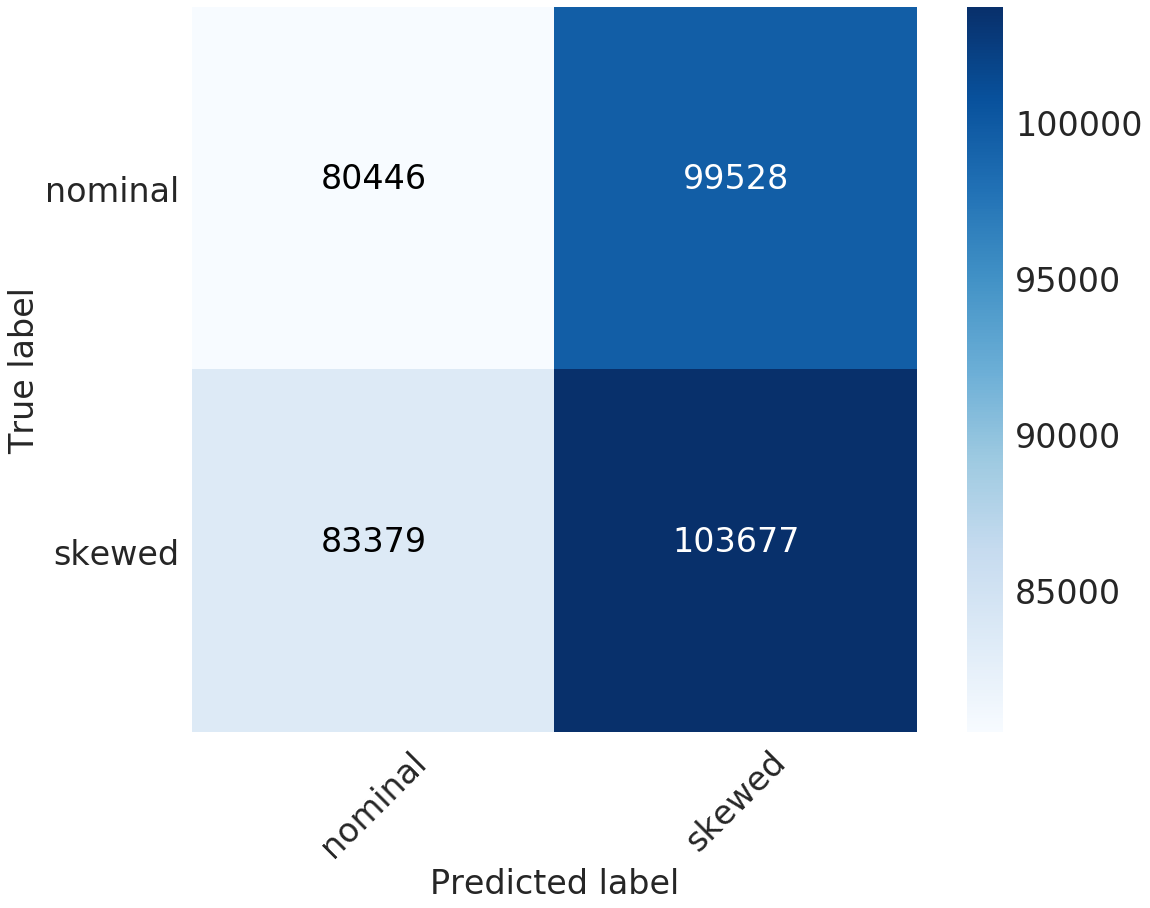

In [161]:
cm = confusion_matrix(y_test, y_pred)
with sns.axes_style('dark'):
    classes =  ['nominal', 'skewed']
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        print(cm[i, j], thresh)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.show()

### Chisquare

In [171]:
nominal_dist, bins = np.histogram(score_nominal, bins='auto')
skewed_dist, _ = np.histogram(score_skewed, bins=bins)

print(nominal_dist.shape, skewed_dist.shape)
print(chisquare(nominal_dist, skewed_dist))


(163,) (163,)
Power_divergenceResult(statistic=580.6035853847654, pvalue=1.721927972564177e-48)


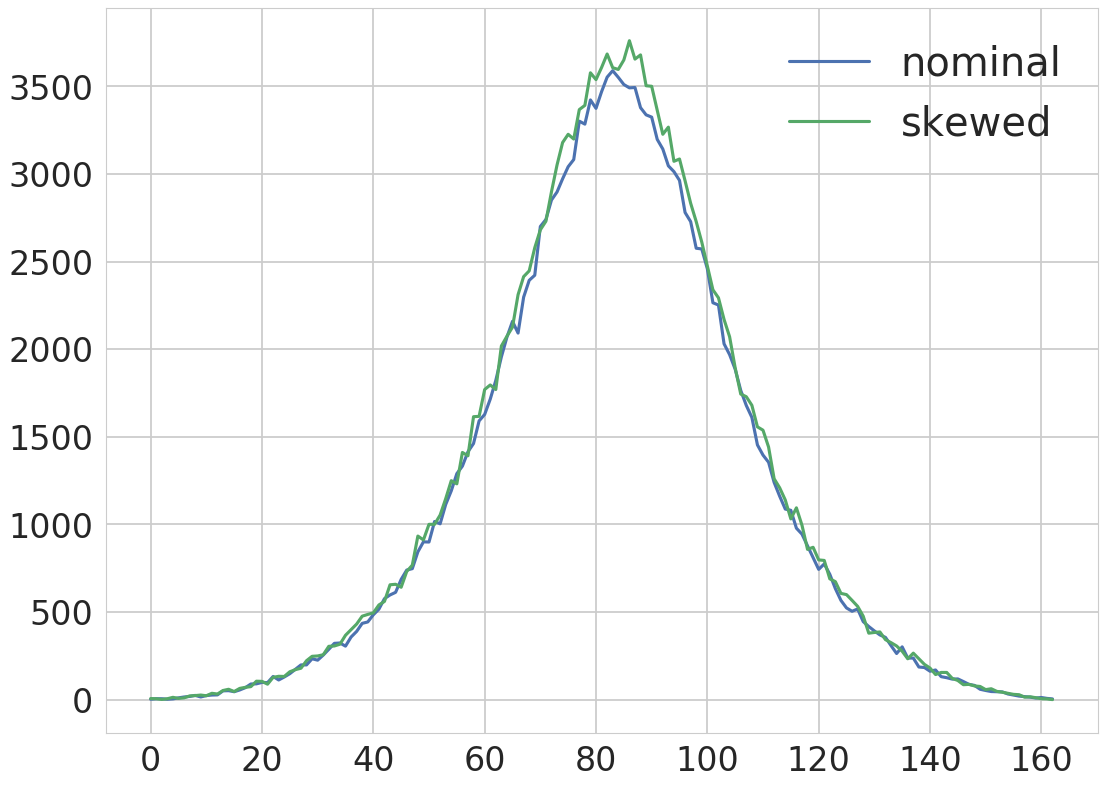

In [166]:
plt.plot(nominal_dist, label='nominal')
plt.plot(skewed_dist, label='skewed')
plt.legend()
plt.show()


In [164]:
skewed_dist

array([   78,   320,   816,  1743,  3295,  5515,  9160, 14391, 20862,
       27266, 29677, 25987, 19048, 12379,  7670,  4496,  2479,  1242,
         509,   122])

In [173]:
12454+13523

25977

In [177]:
25977 / (25977 + 5123 + 3900)

0.7422